## SKUNK Game Analysis

----

Artash Nath
TOPS 2024

----

In [1]:
from numba import jit
from timeit import default_timer as timer   

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm

import seaborn as sns
sns.set()

In [2]:
DECISION_THRESHOLDS = list(range(20, 80)) # At what point-level to quit the game in each SKUNK column
NUM_ITERATIONS = 50000000 # Number of games we want to simulate for each above possibility


# Function to role 2 die
@jit(nopython=True)
def role_die():
    dice1 = random.randint(1,6)
    dice2 = random.randint(1,6)
    return dice1, dice2
    
#############################################################################################################

# Function that plays a single column game assuming the player plans to quit after "DECISION" (1 to 8) rounds
@jit(nopython=True)
def play_game(THRESHOLD):
    
    score_tracking = [0] # Keeping track of the score
    
    i = 0 # Keep track of iteration

    while True: # Play as many rounds until reaching score threshold or till loosing
        i+=1

        # If the total score in the column is greater then the threshold, quit / leave the game
        if sum(score_tracking) >= THRESHOLD:
            break
        
        # Roll both die - if on first iteration and one of die shows one, keep rolling until getting a non-1 value on both die
        while True:
            d1, d2 = role_die() 
            if (i==1) and ((d1==1) or (d2==1)):
                continue
            else:
                break

        # If both die show one, return a -9999999 value to indicate all points for the entire round (all 5 columns) should be removed
        if (d1==1) and (d2==1):
            score_tracking = [-9999999]
            break

        # If one of the die show 1, reset list and return a 0 score
        if (d1==1) or (d2 ==1):
            score_tracking = [0]
            break
            
        # If both die are non-1, append the product of the die to a list
        else:
            score_tracking.append(d1*d2)
            
    # Once the game loop is exited, sum all the individual points and return them as the total score
    score = sum(score_tracking)
    return score

#############################################################################################################
@jit(nopython=True)
def LOOP_ONCE(DECISION):
        
    # Play the game 5 times for each decision (S K U N K)
        
    total_score = sum([play_game(DECISION), 
                       play_game(DECISION), 
                       play_game(DECISION), 
                       play_game(DECISION),
                       play_game(DECISION)])
    
    # Append the total score over 5 columns to the individual score list for the decision number
        
    # If the score is negative (two ones were rolled in one of the games while the player had not yet quit)
    # Then the entire game returns a null score
    if total_score < 0:
        total_score = 0
            
    return total_score 

#############################################################################################################

# List containing indv. score vals for each possibility (non-cumm.)
AVG_SCORE_IDENTIFIERS = []
for i in DECISION_THRESHOLDS:
    AVG_SCORE_IDENTIFIERS.append([0])

count =  0 


#############################################################################################################

for DECISION in tqdm(DECISION_THRESHOLDS): # For every possible "quit threshold"
    
    
    for i in range(NUM_ITERATIONS):  # Repeat experiment predefined number of iterations
        
        total_score = LOOP_ONCE(DECISION)
        AVG_SCORE_IDENTIFIERS[count].append(total_score)
    count+=1
                          
                          

  0%|          | 0/60 [00:00<?, ?it/s]

In [3]:
# Average score obtained from each decision
MEAN_SCORES = [sum(x)/len(x) for x in AVG_SCORE_IDENTIFIERS]

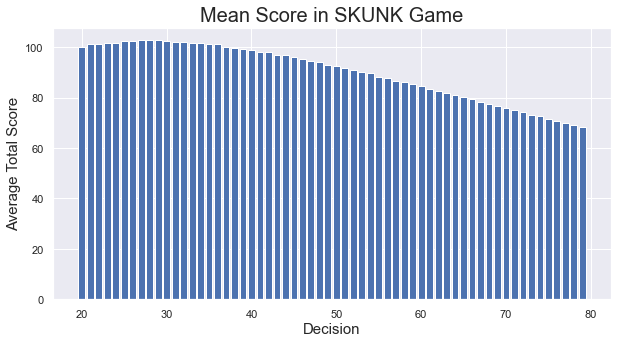

In [4]:
# Plot Mean Scores for each Decision

plt.figure(figsize = (10, 5))
plt.title("Mean Score in SKUNK Game", size=20)
plt.bar(DECISION_THRESHOLDS, MEAN_SCORES)
plt.xlabel("Decision", size=15)
plt.ylabel("Average Total Score", size = 15)
plt.show()

---

In [13]:
MAX_MEAN = MEAN_SCORES[np.argmax(MEAN_SCORES)]
MAX_ARG = DECISION_THRESHOLDS[np.argmax(MEAN_SCORES)]

print("Score is Maximized ({} Avg.) when player quits at {} points in each round".format(round(MAX_MEAN, 3), MAX_ARG))

Score is Maximized (102.716 Avg.) when player quits at 28 points in each round


-----

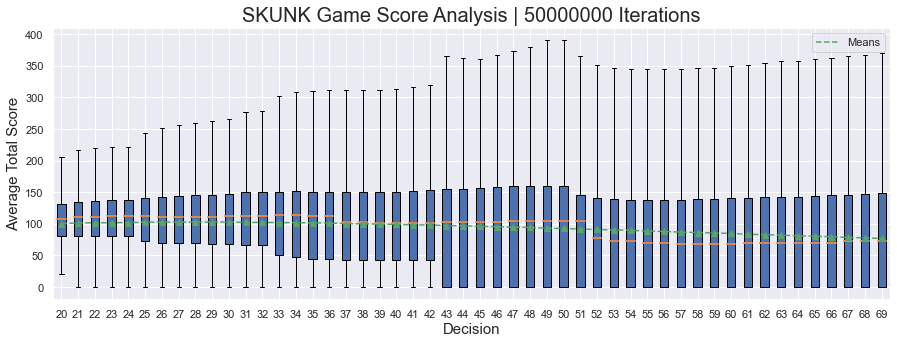

In [14]:
# Create a boxplot for each decision for more in-depth analysis

plt.figure(figsize = (15, 5))
plt.title("SKUNK Game Score Analysis | {} Iterations".format(NUM_ITERATIONS), size=20)

plt.xlabel("Decision", size=15)
plt.ylabel("Average Total Score", size = 15)

plt.boxplot(AVG_SCORE_IDENTIFIERS[:50], 
            showfliers=False, 
            patch_artist=True, 
            showmeans=True, 
            positions = DECISION_THRESHOLDS[:50],
            medianprops={"linewidth": 2})

plt.plot(DECISION_THRESHOLDS[:50], MEAN_SCORES[:50], color = 'g', linestyle='--', label='Means')

plt.legend()
plt.show()